## Code description

This code stacks images of Jupiter and the Crab nebula.

## Begin code

## JUPITER

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from astropy.time import Time
from astropy.coordinates import SkyCoord
from collections import defaultdict
import datetime
from utils import *
from astropy.io import ascii

In [2]:
jupiter_table = ascii.read('../data/jupiter_table.dat')

jupiter_ra = jupiter_table['jupiter_ra'].data # ICRS
jupiter_dec = jupiter_table['jupiter_dec'].data

jdates = jupiter_table['start_date'].data # MJD
jdates = [Time(jd, format="mjd").datetime for jd in jdates]

Total stack (over every ScW)

In [62]:
dir = "../data/Jupiter/15-30keV/Images"
scw_dir = '../data/jupiter_table.dat'

jupiter_scws = [str(id).zfill(12) + ".00" + str(ver) for id, ver in zip(jupiter_table['scw_id'].data, jupiter_table['scw_ver'].data)]

s_var = None
s_flu = None
total_max_isgri_exp = 0

body_lim = {}

body_name = 'Jupiter'

for scw in np.sort(os.listdir(dir)):
    if scw.endswith(".fits"):

        scw_id = scw[:16]
        
        f = fits.open(os.path.join(dir, scw))

        sig = [e for e in f if e.header.get('IMATYPE', None) == "SIGNIFICANCE"][0]
        var = [e for e in f if e.header.get('IMATYPE', None) == "VARIANCE"][0]
        flu = [e for e in f if e.header.get('IMATYPE', None) == "INTENSITY"][0]
        expo = [e for e in f if e.header.get('IMATYPE', None) == "EXPOSURE"][0]

        wcs = WCS(flu.header)

        date_obs = Time(sig.header['DATE-OBS']).datetime

        idx = jupiter_scws.index(scw_id)
        j_ra = jupiter_ra[idx]
        j_dec = jupiter_dec[idx]

        try:
            body_i, body_j = [
            int(i) for i in 
            wcs.world_to_pixel(SkyCoord(j_ra, j_dec, unit="deg"))
            ]
        except Exception as e:
            print(f"Coordinate transform failed: {e}")
            continue

        plot_span = 40
        detection_span = 20

        if False:
            plt.figure(figsize=(4,4))
            plt.imshow(
                #sig.data
                sig.data[body_i-plot_span:body_i+plot_span, body_j-plot_span:body_j+plot_span]
            )

        if False:
            plt.scatter(
                body_i,
                body_j,
                c='r',
                marker='o',
                s=200,
                alpha=0.2
            )

            plt.clim([0,6])

        f = flu.data[body_i-detection_span:body_i+detection_span, body_j-detection_span:body_j+detection_span]
        v = var.data[body_i-detection_span:body_i+detection_span, body_j-detection_span:body_j+detection_span]
        ex = expo.data[body_i-detection_span:body_i+detection_span, body_j-detection_span:body_j+detection_span]

        try:
            if s_var is None:
                s_var = v.copy()
                s_flu = f.copy()
                s_expo = ex.copy()
                ref_wcs = wcs.deepcopy()
                ref_j_ra, ref_j_dec = j_ra, j_dec  # Jupiter's sky position
                ref_i, ref_j = body_i, body_j      # Jupiter's pixel position
            else:
                m = ~np.isnan(v)
                m &= v > 0
                
                s_flu[m] = (f[m]/v[m] + s_flu[m]/s_var[m])/(1/v[m] + 1/s_var[m])
                s_var[m] = 1/(1/v[m] + 1/s_var[m])
                s_expo[m] += ex[m]
                total_max_isgri_exp += np.nanmax(expo.data)
        except:
            print("fail to read!")
            continue
            
    
        body_lim[scw] = dict(
            ic = np.nanmean(v**0.5), 
            ic_std = np.nanstd(f), 
        )

Set MJD-OBS to 54559.124931 from DATE-OBS.
Set MJD-END to 54559.166273 from DATE-END'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 54559.167616 from DATE-OBS.
Set MJD-END to 54559.208958 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 54559.253125 from DATE-OBS.
Set MJD-END to 54559.294468 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 54559.295810 from DATE-OBS.
Set MJD-END to 54559.337153 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 54559.338495 from DATE-OBS.
Set MJD-END to 54559.379838 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 54559.381169 from DATE-OBS.
Set MJD-END to 54559.422523 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 54559.466539 from DATE-OBS.
Set MJD-END to 54559.507894 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 54559.552037 from DATE-OBS.
Set MJD-END to 54559.593380 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 54559.594722 from DATE-OBS.
Set MJD-END to 54559.636065 from DATE-END'. [astr

Plotting

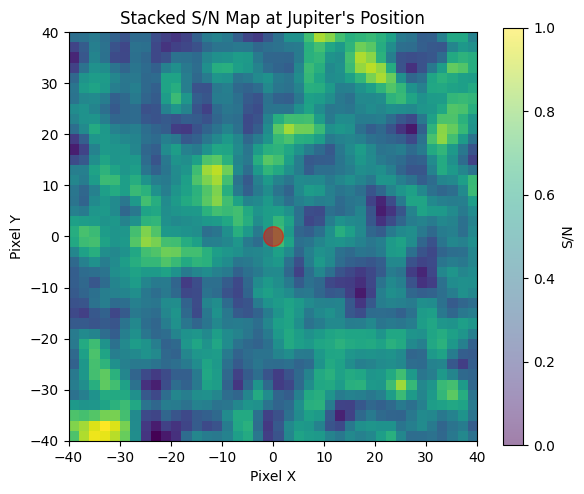

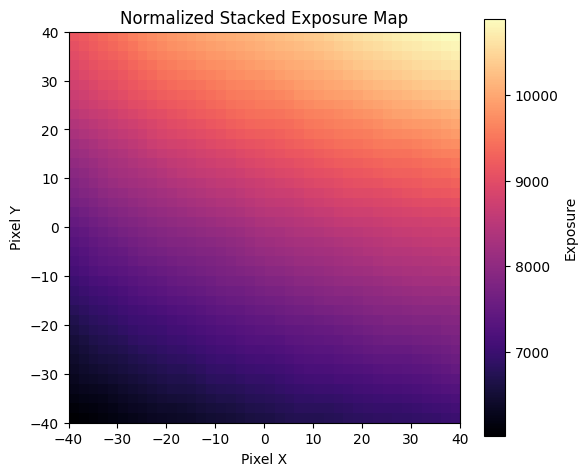

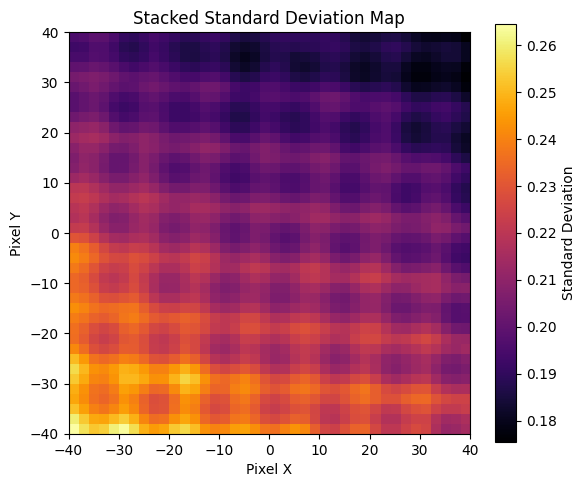

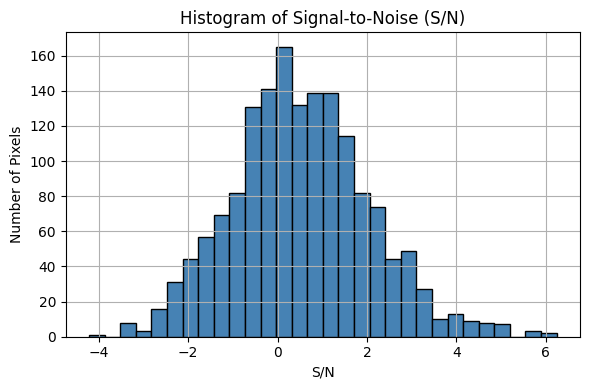

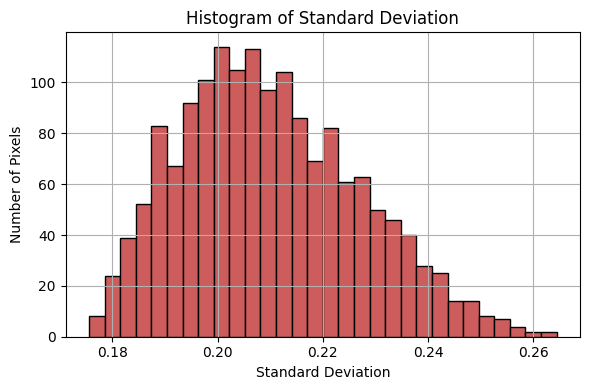

In [63]:
extent = [-plot_span, plot_span, -plot_span, plot_span]

# Signal-to-noise (S/N) map
plt.figure(figsize=(6, 5))
plt.imshow(s_flu / np.sqrt(s_var), origin='lower', cmap='viridis', extent=extent)
plt.title("Stacked S/N Map at Jupiter's Position")
plt.scatter(0, 0, c='r', marker='o', s=200, alpha=0.5, label="Jupiter Position")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")
cbar = plt.colorbar()
cbar.set_label("S/N")
plt.tight_layout()

# Effective exposure map (normalized)
plt.figure(figsize=(6, 5))
plt.imshow(s_expo , origin='lower', cmap='magma', extent=extent) # / total_max_isgri_exp
plt.title("Normalized Stacked Exposure Map")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")
cbar = plt.colorbar()
cbar.set_label("Exposure")
plt.tight_layout()

# Square root of the variance map
plt.figure(figsize=(6, 5))
plt.imshow(np.sqrt(s_var), origin='lower', cmap='inferno', extent=extent)
plt.title("Stacked Standard Deviation Map")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")
cbar = plt.colorbar()
cbar.set_label("Standard Deviation")
plt.tight_layout()

# Histogram of S/N
plt.figure(figsize=(6, 4))
plt.hist((s_flu / np.sqrt(s_var)).flatten(), bins=30, color='steelblue', edgecolor='black')
plt.title("Histogram of Signal-to-Noise (S/N)")
plt.xlabel("S/N")
plt.ylabel("Number of Pixels")
plt.grid(True)
plt.tight_layout()

# Histogram of √variance
plt.figure(figsize=(6, 4))
plt.hist(np.sqrt(s_var).flatten(), bins=30, color='indianred', edgecolor='black')
plt.title("Histogram of Standard Deviation")
plt.xlabel("Standard Deviation")
plt.ylabel("Number of Pixels")
plt.grid(True)
plt.tight_layout()

S/N at the center of the stacked map: 0.41
Probability of observing S/N >= 0.41: 53.17%


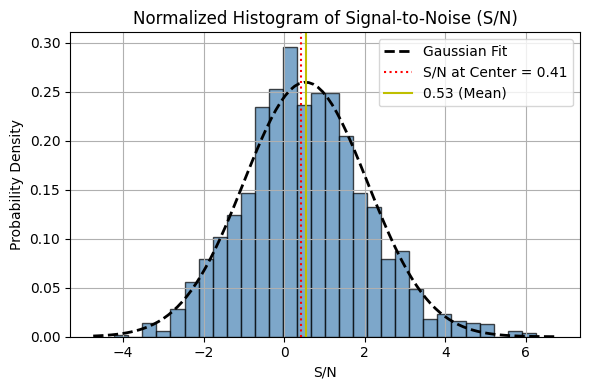

In [70]:
from scipy.stats import norm

# Normalize S/N histogram 
s_n_values = (s_flu / np.sqrt(s_var)).flatten() 
hist, bin_edges = np.histogram(s_n_values, bins=30, density=True) 

bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

mu, std = norm.fit(s_n_values)

# Plot the normalized S/N histogram
plt.figure(figsize=(6, 4))
plt.hist(s_n_values, bins=30, color='steelblue', edgecolor='black', density=True, alpha=0.7)
plt.title("Normalized Histogram of Signal-to-Noise (S/N)")
plt.xlabel("S/N")
plt.ylabel("Probability Density")

# Plot the Gaussian fit
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k--', linewidth=2, label="Gaussian Fit")
plt.legend()
plt.grid(True)
plt.tight_layout()

body_i = np.clip(body_i, plot_span, s_flu.shape[0] - plot_span - 1)
body_j = np.clip(body_j, plot_span, s_flu.shape[1] - plot_span - 1)

center_sn = s_flu[body_i, body_j] / np.sqrt(s_var[body_i, body_j])
#center_sn = s_flu[0, 0] / np.sqrt(s_var[0, 0])
print(f"S/N at the center of the stacked map: {center_sn:.2f}")

plt.axvline(center_sn, color='r', linestyle=':', label=f"S/N at Center = {center_sn:.2f}")
plt.axvline(mu, color='y', linestyle='-', label=f"{mu:.2f} (Mean)")

plt.legend()
plt.tight_layout()

probability = norm.cdf(center_sn, mu, std)
print(f"Probability of observing S/N >= {center_sn:.2f}: {(1 - probability)*100:.2f}%")

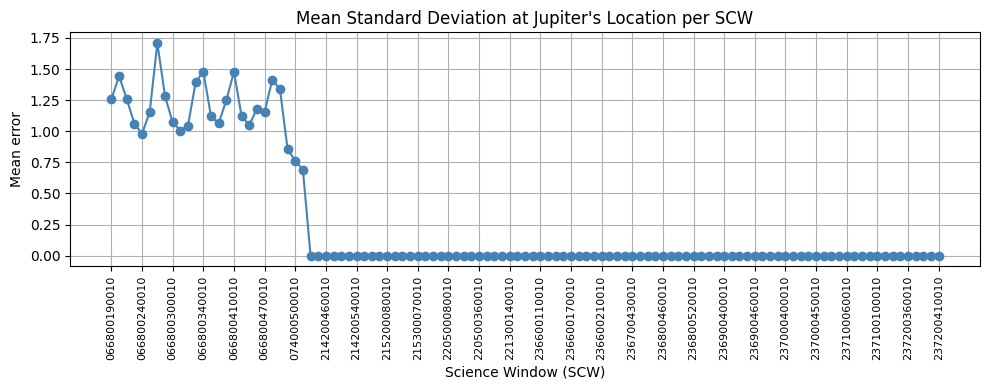

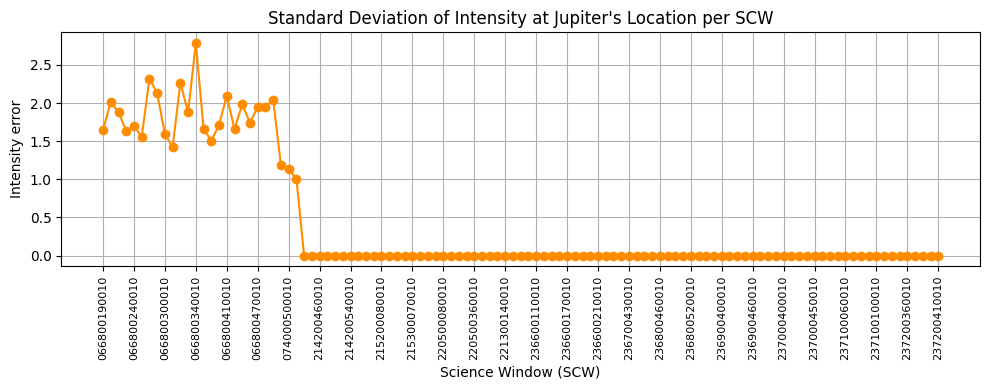

In [34]:
scws = list(body_lim.keys())
mean_std_devs = [body_lim[scw]['ic'] for scw in scws]
intensity_stds = [body_lim[scw]['ic_std'] for scw in scws]

# Plot 1: Mean standard deviation (√variance) per SCW
plt.figure(figsize=(10, 4))
plt.plot(scws, mean_std_devs, marker='o', linestyle='-', color='steelblue')
plt.xticks(rotation=90, fontsize=8, ticks=[i for i in range(len(scws)) if i % 4 == 0], labels=[s[:12] for i,s in enumerate(scws) if i % 4 == 0])
plt.title("Mean Standard Deviation at Jupiter's Location per SCW")
plt.ylabel("Mean error")
plt.xlabel("Science Window (SCW)")
plt.grid(True)
plt.tight_layout()

# Plot 2: Intensity standard deviation per SCW
plt.figure(figsize=(10, 4))
plt.plot(scws, intensity_stds, marker='o', linestyle='-', color='darkorange')
plt.xticks(rotation=90, fontsize=8, ticks=[i for i in range(len(scws)) if i % 4 == 0], labels=[s[:12] for i,s in enumerate(scws) if i % 4 == 0])
plt.title("Standard Deviation of Intensity at Jupiter's Location per SCW")
plt.ylabel("Intensity error")
plt.xlabel("Science Window (SCW)")
plt.grid(True)
plt.tight_layout()

Monthly stack

In [6]:
dir = "../data/Jupiter/15-30keV/Images"

detection_span = 20
extent = [-detection_span, detection_span, -detection_span, detection_span]

monthly_stack = defaultdict(lambda: {
    's_flu': None,
    's_var': None,
    's_expo': None,
    'count': 0
})

body_name = 'Jupiter'

for scw in np.sort(os.listdir(dir)):
    if not scw.endswith(".fits"):
        continue

    try:
        f = fits.open(os.path.join(dir, scw))
        sig = [e for e in f if e.header.get('IMATYPE') == "SIGNIFICANCE"][0]
        var = [e for e in f if e.header.get('IMATYPE') == "VARIANCE"][0]
        flu = [e for e in f if e.header.get('IMATYPE') == "INTENSITY"][0]
        expo = [e for e in f if e.header.get('IMATYPE') == "EXPOSURE"][0]

        wcs = WCS(sig.header)
        date_obs = Time(sig.header['DATE-OBS']).datetime
        key = (date_obs.year, date_obs.month)
        
        # Find Jupiter position closest in time
        closest_idx = np.argmin(np.abs([jdates[i] - date_obs for i in range(len(jdates))]))
        j_ra = jupiter_ra[closest_idx]
        j_dec = jupiter_dec[closest_idx]
        coord = SkyCoord(j_ra, j_dec, unit="deg")
        body_i, body_j = [int(i) for i in wcs.world_to_pixel(coord)]

        # Crop around Jupiter
        f_crop = flu.data[body_i-detection_span:body_i+detection_span, body_j-detection_span:body_j+detection_span]
        v_crop = var.data[body_i-detection_span:body_i+detection_span, body_j-detection_span:body_j+detection_span]
        e_crop = expo.data[body_i-detection_span:body_i+detection_span, body_j-detection_span:body_j+detection_span]
        
        # Check if cropped region has the right shape
        if f_crop.shape != (2 * detection_span, 2 * detection_span):
            print(f"Skipping {scw} due to crop shape: {f_crop.shape}")
            continue

        # Stack
        stack = monthly_stack[key]
        if stack['s_var'] is None:
            stack['s_flu'] = f_crop.copy()
            stack['s_var'] = v_crop.copy()
            stack['s_expo'] = e_crop.copy()
        else:
            m = ~np.isnan(v_crop)
            m &= v_crop > 0

            stack['s_flu'][m] = (f_crop[m]/v_crop[m] + stack['s_flu'][m]/stack['s_var'][m]) / (1/v_crop[m] + 1/stack['s_var'][m])
            stack['s_var'][m] = 1/(1/v_crop[m] + 1/stack['s_var'][m])
            stack['s_expo'][m] += e_crop[m]

        stack['count'] += 1

    except Exception as e:
        print(f"Failed on {scw}: {e}")
        continue

Light Curve

In [7]:
monthly_dates = []
monthly_sn = []

for (year, month), stack in sorted(monthly_stack.items()):
    if stack['s_flu'] is None or stack['s_var'] is None:
        continue
    if stack['s_flu'].shape != (2 * detection_span, 2 * detection_span):
        continue

    sn_map = stack['s_flu'] / np.sqrt(stack['s_var'])
    center_sn = sn_map[detection_span, detection_span]

    monthly_dates.append(datetime(year, month, 15))  # mid-month
    monthly_sn.append(center_sn)


/tmp/ipykernel_14643/750016879.py:10: RuntimeWarning: invalid value encountered in divide
  sn_map = stack['s_flu'] / np.sqrt(stack['s_var'])


Plotting

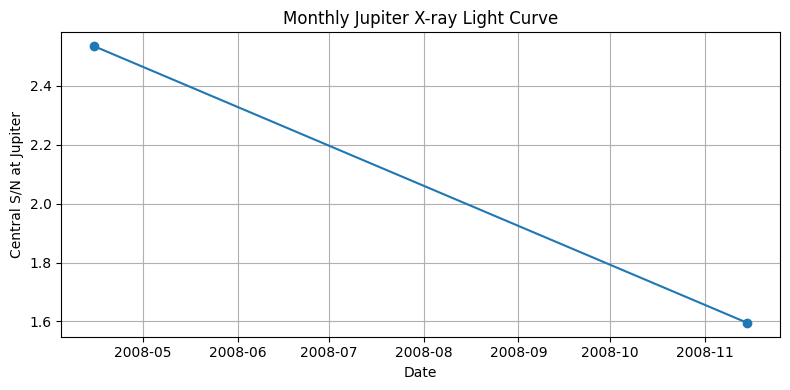

In [8]:
plt.figure(figsize=(8, 4))
plt.plot(monthly_dates, monthly_sn, marker='o')
plt.xlabel("Date")
plt.ylabel("Central S/N at Jupiter")
plt.title("Monthly Jupiter X-ray Light Curve")
plt.grid(True)
plt.tight_layout()

## CRAB

In [56]:
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from astropy.time import Time
from astropy.coordinates import SkyCoord
from collections import defaultdict
import datetime
from utils import *
from astropy.io import ascii

In [57]:
crab_coords = SkyCoord.from_name("Crab")
crab_ra = crab_coords.ra.deg
crab_dec = crab_coords.dec.deg

In [58]:
#dir = "../data/Crab/15-30keV/Images"
dir = "../data/Crab/30-60keV/Images"
#dir = "../data/Crab/3-15keV/Images"

s_var = None
s_flu = None
s_expo = None
total_max_isgri_exp = 0

body_lim = {}

body_name = 'Crab'

for scw in np.sort(os.listdir(dir)):
    if scw.endswith(".fits"):

        try:

            scw_id = scw[:16]
            
            f = fits.open(os.path.join(dir, scw))
            if dir == "../data/Crab/3-15keV/Images":
                flu = [e for e in f if e.header.get('IMATYPE', None) == "RECONSTRUCTED"][0]
            else:
                flu = [e for e in f if e.header.get('IMATYPE', None) == "INTENSITY"][0]
            sig = [e for e in f if e.header.get('IMATYPE', None) == "SIGNIFICANCE"][0]
            var = [e for e in f if e.header.get('IMATYPE', None) == "VARIANCE"][0]
            expo = [e for e in f if e.header.get('IMATYPE', None) == "EXPOSURE"][0]

            wcs = WCS(sig.header)

            try:
                body_i, body_j = [
                    int(i) for i in 
                    wcs.world_to_pixel(SkyCoord(crab_ra, crab_dec, unit="deg"))
                ]
            except Exception as e:
                print(f"Coordinate transform failed: {e}")
                continue

            plot_span = 20
            detection_span = 20

            if False:
                plt.figure(figsize=(4,4))
                plt.imshow(
                    sig.data[body_i-plot_span:body_i+plot_span, body_j-plot_span:body_j+plot_span]
                )

            if False:
                plt.scatter(
                    body_i,
                    body_j,
                    c='r',
                    marker='o',
                    s=200,
                    alpha=0.2
                )
                plt.clim([0, 6])

            f = flu.data[body_i-detection_span:body_i+detection_span, body_j-detection_span:body_j+detection_span]
            v = var.data[body_i-detection_span:body_i+detection_span, body_j-detection_span:body_j+detection_span]
            ex = expo.data[body_i-detection_span:body_i+detection_span, body_j-detection_span:body_j+detection_span]

            # Check if cropped region has the right shape
            if f.shape != (2 * detection_span, 2 * detection_span):
                print(f"Skipping {scw} due to crop shape: {f.shape}")
                continue

            try:
                if s_var is None:
                    s_var = v.copy()
                    s_flu = f.copy()
                    s_expo = ex.copy()
                else:
                    m = ~np.isnan(v)
                    m &= v > 0

                    s_flu[m] = (f[m]/v[m] + s_flu[m]/s_var[m])/(1/v[m] + 1/s_var[m])
                    s_var[m] = 1/(1/v[m] + 1/s_var[m])
                    s_expo[m] += ex[m]
                    total_max_isgri_exp += np.nanmax(expo.data)
            except Exception as e:
                print(f"Failed to process SCW {scw_id}: {e}")
                continue

            body_lim[scw] = dict(
                ic=np.nanmean(np.sqrt(v)), 
                ic_std=np.nanstd(f),
            )
        except Exception as e:
            print(f"Failed to read {scw}: {e}")
            continue

Set MJD-OBS to 52695.589734 from DATE-OBS.
Set MJD-END to 52695.614757 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 52866.475914 from DATE-OBS.
Set MJD-END to 52866.501366 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 53070.792419 from DATE-OBS.
Set MJD-END to 53070.813241 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 53277.533958 from DATE-OBS.
Set MJD-END to 53277.554780 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 53458.589340 from DATE-OBS.
Set MJD-END to 53458.610162 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 53615.317153 from DATE-OBS.
Set MJD-END to 53615.358484 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 53654.356829 from DATE-OBS.
Set MJD-END to 53654.377662 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 53823.883449 from DATE-OBS.
Set MJD-END to 53823.900799 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 54007.336030 from DATE-OBS.
Set MJD-END to 54007.353553 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 54178.916424 from DATE-OBS.
Set MJD-END 

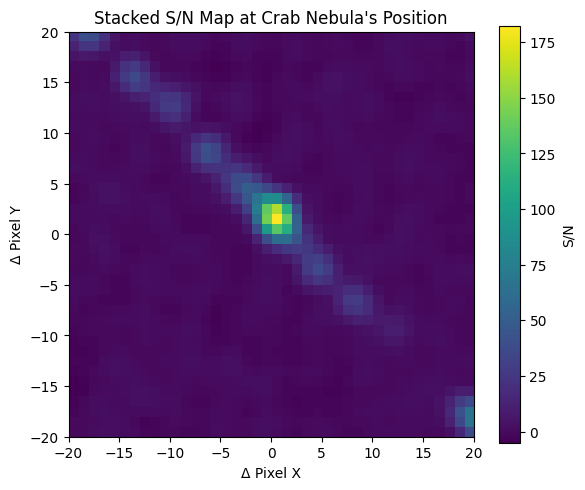

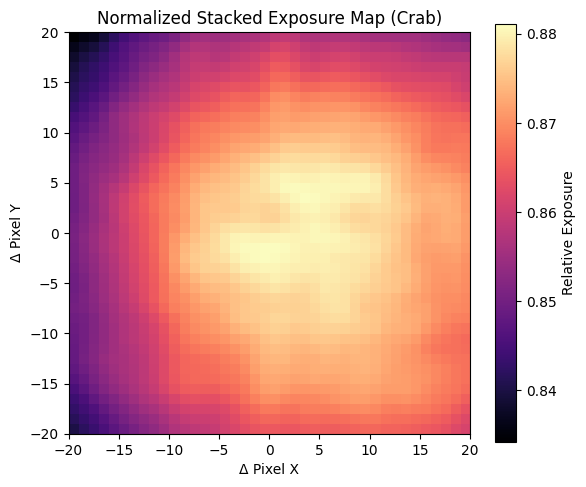

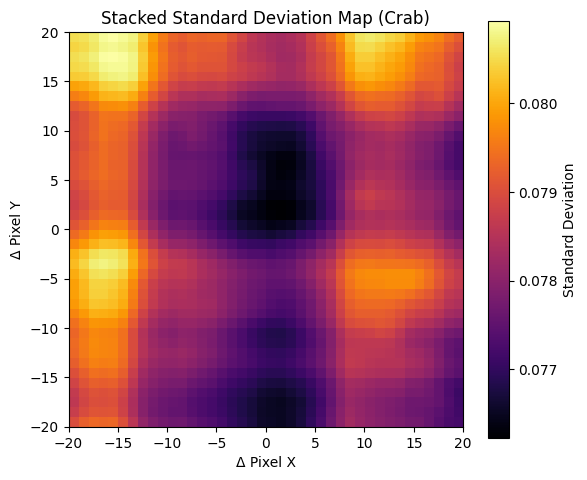

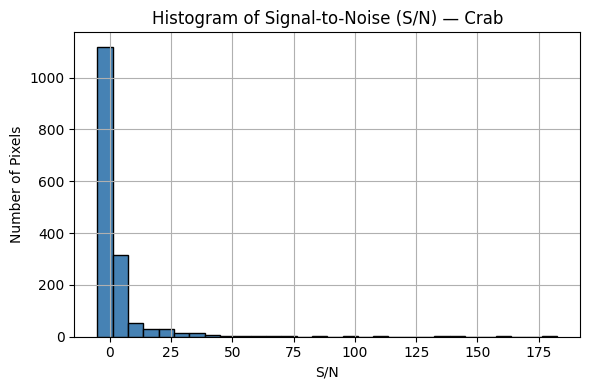

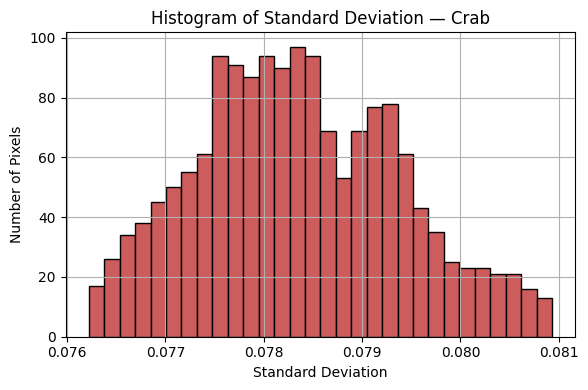

In [59]:
extent = [-detection_span, detection_span, -detection_span, detection_span]

# Signal-to-noise (S/N) map
plt.figure(figsize=(6, 5))
plt.imshow(s_flu / np.sqrt(s_var), origin='lower', cmap='viridis', extent=extent)
plt.title("Stacked S/N Map at Crab Nebula's Position")
plt.xlabel("Δ Pixel X")
plt.ylabel("Δ Pixel Y")
cbar = plt.colorbar()
cbar.set_label("S/N")
plt.tight_layout()

# Effective exposure map (normalized)
plt.figure(figsize=(6, 5))
plt.imshow(s_expo / total_max_isgri_exp, origin='lower', cmap='magma', extent=extent)
plt.title("Normalized Stacked Exposure Map (Crab)")
plt.xlabel("Δ Pixel X")
plt.ylabel("Δ Pixel Y")
cbar = plt.colorbar()
cbar.set_label("Relative Exposure")
plt.tight_layout()

# Square root of the variance map
plt.figure(figsize=(6, 5))
plt.imshow(np.sqrt(s_var), origin='lower', cmap='inferno', extent=extent)
plt.title("Stacked Standard Deviation Map (Crab)")
plt.xlabel("Δ Pixel X")
plt.ylabel("Δ Pixel Y")
cbar = plt.colorbar()
cbar.set_label("Standard Deviation")
plt.tight_layout()

# Histogram of S/N
plt.figure(figsize=(6, 4))
plt.hist((s_flu / np.sqrt(s_var)).flatten(), bins=30, color='steelblue', edgecolor='black')
plt.title("Histogram of Signal-to-Noise (S/N) — Crab")
plt.xlabel("S/N")
plt.ylabel("Number of Pixels")
plt.grid(True)
plt.tight_layout()

# Histogram of √variance
plt.figure(figsize=(6, 4))
plt.hist(np.sqrt(s_var).flatten(), bins=30, color='indianred', edgecolor='black')
plt.title("Histogram of Standard Deviation — Crab")
plt.xlabel("Standard Deviation")
plt.ylabel("Number of Pixels")
plt.grid(True)
plt.tight_layout()
